In [17]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# import Keras Network lib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, GRU

# import RMSE,MSE,MAPE lib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score

In [18]:
# 2. Đọc file csv và gắng index với giá Close
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/My Drive/PTDLKD/ETH-USD.csv',index_col=0,parse_dates=True)


df1=df[['Close']]
df1.head(10)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Close
Date,
2018-01-01,772.640991
2018-01-02,884.443970
2018-01-03,962.719971
2018-01-04,980.921997
2018-01-05,997.719971
2018-01-06,1041.680054
2018-01-07,1153.170044
2018-01-08,1148.530029
2018-01-09,1299.739990


In [19]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [32]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [33]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [34]:
#6. Reshape into X=t,t+1,t+2..t+49 and Y=t+40

time_step = 40
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [35]:
# 7. Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [36]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [37]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
23/23 [==============================] - 4s 47ms/step - loss: 0.0176 - val_loss: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 29ms/step - loss: 0.0011 - val_loss: 4.6576e-04
Epoch 3/100
23/23 [==============================] - 1s 44ms/step - loss: 5.3154e-04 - val_loss: 4.3893e-04
Epoch 4/100
23/23 [==============================] - 1s 43ms/step - loss: 4.6970e-04 - val_loss: 4.5204e-04
Epoch 5/100
23/23 [==============================] - 1s 42ms/step - loss: 4.6637e-04 - val_loss: 4.1611e-04
Epoch 6/100
23/23 [==============================] - 1s 42ms/step - loss: 4.4835e-04 - val_loss: 4.0086e-04
Epoch 7/100
23/23 [==============================] - 1s 45ms/step - loss: 4.2412e-04 - val_loss: 3.8742e-04
Epoch 8/100
23/23 [==============================] - 1s 43ms/step - loss: 4.1588e-04 - val_loss: 3.8197e-04
Epoch 9/100
23/23 [==============================] - 1s 45ms/step - loss: 3.9863e-04 - val_loss: 3.6808e-04
Epoch 10/100
23/23 [====================

In [38]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 6ms/step


In [40]:
rmse = mean_squared_error(ytest, y_pred, squared=False)
print("RMSE on test set: {:.3f}".format(rmse))
rmse = mean_squared_error(yval, y_pred_val, squared=False)
print("RMSE on validation set: {:.3f}".format(rmse))
mape = mean_absolute_percentage_error(ytest, y_pred)
print("MAPE on test set: {:.3f}".format(mape))
mape = mean_absolute_percentage_error(yval, y_pred_val)
print("MAPE on validation set: {:.3f}".format(mape))
evs = explained_variance_score(ytest, y_pred)
print("The explained variance score (EVS) on test set: {:.3f}".format(evs))
evs = explained_variance_score(yval, y_pred_val)
print("The explained variance score (EVS) on validate set: {:.3f}".format(evs))

RMSE on test set: 0.016
RMSE on validation set: 0.007
MAPE on test set: 0.032
MAPE on validation set: 0.014
The explained variance score (EVS) on test set: 0.985
The explained variance score (EVS) on validate set: 0.920


In [41]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [42]:
# 13. Dự báo 30 ngày tiếp theo
x_input = val_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()



lst_output = []
n_steps = 100
i = 0
while i < 30 and len(temp_input) >= n_steps:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


0 day input [0.37510924 0.37815887 0.37566241 0.37870563 0.38004325 0.37593455
 0.37477514 0.37808108 0.371164   0.37032783 0.36875763 0.37029641
 0.36870457 0.3685939  0.37470005 0.37438071 0.37363106 0.37286346
 0.3732369  0.37120428 0.3722419  0.36859261 0.36409289 0.33855752
 0.33348359 0.33528716 0.3385403  0.33482122 0.32776157 0.33736054
 0.33327198 0.33178935 0.33038736 0.33275767 0.33168832 0.34803179
 0.34282564 0.33024615 0.32661909 0.32842421 0.32823221 0.32686531
 0.3277059  0.32741462 0.33066054 0.32823647 0.32803014 0.32415232
 0.31036336 0.31899146 0.32228245 0.32629825 0.32940035 0.32804269
 0.32543577 0.32849224 0.32980314 0.32543448 0.31727343 0.31916889
 0.31929357 0.31654294 0.31812285 0.31920039 0.3200621  0.33177827
 0.33496395 0.33564461 0.34889577 0.33405098 0.33258266 0.33071127
 0.3230202  0.33028685 0.32789242 0.32768881 0.31632154 0.31376354
 0.3134551  0.30781982 0.31045892 0.31112886 0.31172385 0.32070576
 0.31328267 0.31292528 0.3137094  0.32157987 0.326

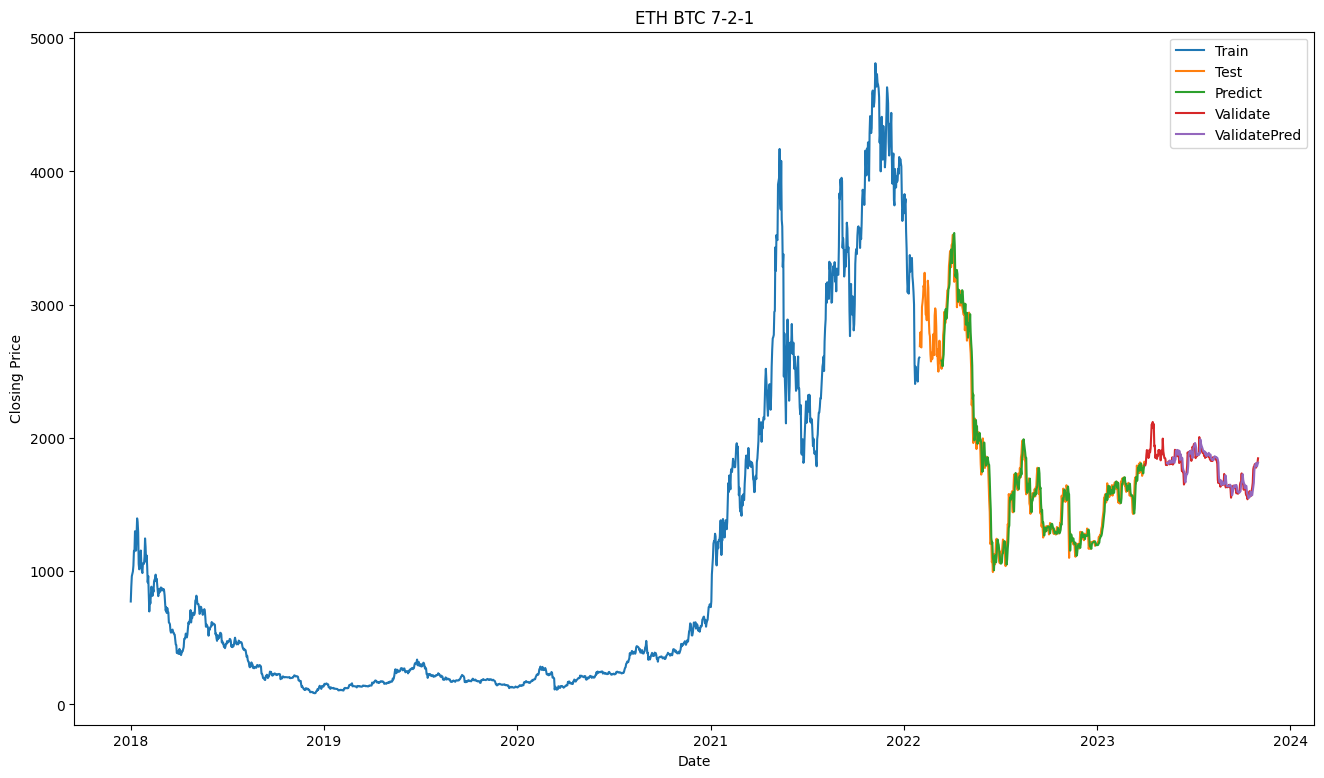

In [43]:
# 16.Vẽ hình
plt.figure(figsize=(16,9))
plt.ylabel('Closing Price');
plt.xlabel('Date');
plt.title('ETH BTC 7-2-1')
train_index = df[:train_size].index
plt.plot(train_index,scaler.inverse_transform(train_data))
#test
test_index = df[train_size:train_size+test_size].index
plt.plot(test_index,scaler.inverse_transform(test_data))
#test predict
test_predict_index = df[train_size+41:train_size+test_size].index
plt.plot(test_predict_index,(y_pred))
#val
val_index = df[train_size+test_size:train_size+test_size+val_size].index
plt.plot(val_index,scaler.inverse_transform(val_data))
#val predict
val_predict_index = df[train_size+test_size+41:train_size+test_size+val_size].index
plt.plot(val_predict_index,y_pred_val)
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

